# 温度关联分析
## 邱中凯
## 2018-06-11

# ====================

In [1]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

## 1  问题提出

除去齿轮箱与发电机系统内的温度测点，信息系统内的102个测点，剩余的温度测点有12个，具体如下所示：

* r39- 变流器网测模块温度
* r40- 变流器机侧模块温度
* r58- 主轴承温度
* r76- 桨叶1电机温度
* r78- 桨叶2电机温度
* r80- 桨叶3电机温度
* r81- 塔底控制柜温度
* r82- 塔底温度
* r83- 机舱控制柜温度
* r84- 机舱温度
* r85- 箱变变压器温度
* r86- 环境温度

这些温度之间有相关性如何，是否需要单独建模考虑，下面将进行详细的分析

## 2 数据处理

In [10]:
# 读取数据
import os
import pandas as pd
import numpy as np

FILE_PATH = r'D:\00_工作日志\O\2018-06\赤峰项目故障\data\赤峰二期5min数据'
FILE_NAME = 'CFEQ_wt2_5min_201601-201712.csv'

os.chdir(FILE_PATH)
df = pd.read_csv(FILE_NAME, index_col=0)
df.index = pd.to_datetime(df.index)
df.shape

(208512, 101)

### 2.1 筛选变量

* 温度变量： 从信息系统102个测点中，筛选出除齿轮箱与发电机系统外所有的温度变量
* 其它变量： 筛选出功率、风速、发电机转速变量作为协助分析
##### 综合筛选的变量有：['r18',  'r43',  'r47',  'r39',  'r40',  'r58',  'r76',  'r78',  'r80',  'r81',  'r82',  'r83',  'r84',  'r85',  'r86']

### 2.2 筛选正常发电状态

* 功率- r18： r18 > 5
* 转速- r47： r47 > 0

In [25]:
cols = ['r18', 'r43', 'r47', 'r39', 'r40', 'r58', 'r76', 'r78', 'r80', 'r81', 'r82', 'r83', 'r84', 'r85', 'r86']
df = df.loc[:, cols]
df = df[df['r18'] > 5] # 筛选功率 > 5
df = df[df['r47'] > 1000] # 筛选功率 > 5
df.shape

(121418, 15)

In [26]:
df.head()

,r18,r43,r47,r39,r40,r58,r76,r78,r80,r81,r82,r83,r84,r85,r86
r1,,,,,,,,,,,,,,,
2016-01-05 07:00:00,878.0,9.327,1638.0,7.0,8.0,0.0,-36.9,-38.9,-38.9,12.2,-8.0,-3.0,-10.0,NaN,-17.0
2016-01-05 07:05:00,877.0,10.458,1637.0,-6.9,-1.9,0.0,-34.9,-35.9,-35.9,10.2,-8.0,-2.0,-8.0,NaN,-17.0
2016-01-05 07:10:00,878.0,10.248,1633.0,-7.9,-3.9,0.0,-32.9,-34.9,-34.9,8.2,-8.0,-2.0,-8.0,NaN,-17.0
2016-01-05 07:15:00,878.0,9.637,1676.0,-6.9,-3.9,0.0,-31.9,-32.9,-32.9,6.2,-9.0,-2.0,-8.0,NaN,-17.0
2016-01-05 07:20:00,873.0,10.594,1647.0,-6.9,-3.9,0.0,-30.9,-31.9,-31.9,5.2,-9.0,-2.0,-7.0,NaN,-17.0


### 2.3 查看数据信息

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121418 entries, 2016-01-05 07:00:00 to 2017-12-31 23:55:00
Data columns (total 15 columns):
r18    121418 non-null float64
r43    121418 non-null float64
r47    121418 non-null float64
r39    121418 non-null float64
r40    121418 non-null float64
r58    121418 non-null float64
r76    121418 non-null float64
r78    121418 non-null float64
r80    121418 non-null float64
r81    121418 non-null float64
r82    121418 non-null float64
r83    121418 non-null float64
r84    121418 non-null float64
r85    0 non-null float64
r86    121418 non-null float64
dtypes: float64(15)
memory usage: 14.8 MB


##### 可见
* r85- 箱变变压器温度: 数据太少，删除此列，暂时不考虑此温度
* r58- 主轴承温度：数据缺失，删除缺失行

In [28]:
# 删除r85列，并删除r58缺失数据的行
df = df.drop(['r85'], axis=1)
df = df.dropna(how='any', axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121418 entries, 2016-01-05 07:00:00 to 2017-12-31 23:55:00
Data columns (total 14 columns):
r18    121418 non-null float64
r43    121418 non-null float64
r47    121418 non-null float64
r39    121418 non-null float64
r40    121418 non-null float64
r58    121418 non-null float64
r76    121418 non-null float64
r78    121418 non-null float64
r80    121418 non-null float64
r81    121418 non-null float64
r82    121418 non-null float64
r83    121418 non-null float64
r84    121418 non-null float64
r86    121418 non-null float64
dtypes: float64(14)
memory usage: 13.9 MB


### 2.4 查看数据描述

In [29]:
df.describe()

,r18,r43,r47,r39,r40,r58,r76,r78,r80,r81,r82,r83,r84,r86
count,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000,121418.000000
mean,668.851299,6.438035,1395.035085,19.411736,21.012850,22.944653,-4.559189,-4.845726,-5.148467,18.176651,11.911698,18.252419,13.855039,4.719219
std,569.568159,2.753606,262.022693,12.376252,12.684382,8.449634,14.587455,14.408036,14.261524,11.213214,11.999938,9.769516,10.414872,12.659617
min,6.000000,0.608000,1039.000000,-15.900000,-12.900000,-8.000000,-50.900000,-49.900000,-52.900000,-14.000000,-20.000000,-12.000000,-20.000000,-30.000000
25%,218.000000,4.398000,1104.000000,9.000000,11.000000,16.300000,-13.900000,-14.900000,-14.900000,8.000000,1.000000,11.200000,7.000000,-6.000000
50%,485.000000,6.011000,1352.000000,20.000000,22.000000,22.800000,-5.900000,-5.900000,-5.900000,17.000000,11.800000,19.000000,14.400000,5.000000
75%,951.750000,7.951750,1689.000000,30.000000,31.000000,30.500000,6.000000,6.000000,5.000000,28.100000,22.300000,26.000000,22.200000,15.600000
max,2114.000000,27.752000,1929.000000,50.000000,56.000000,42.000000,33.000000,29.000000,30.000000,43.900000,39.800000,40.000000,39.200000,36.000000


### 2.5 查看数据直方图

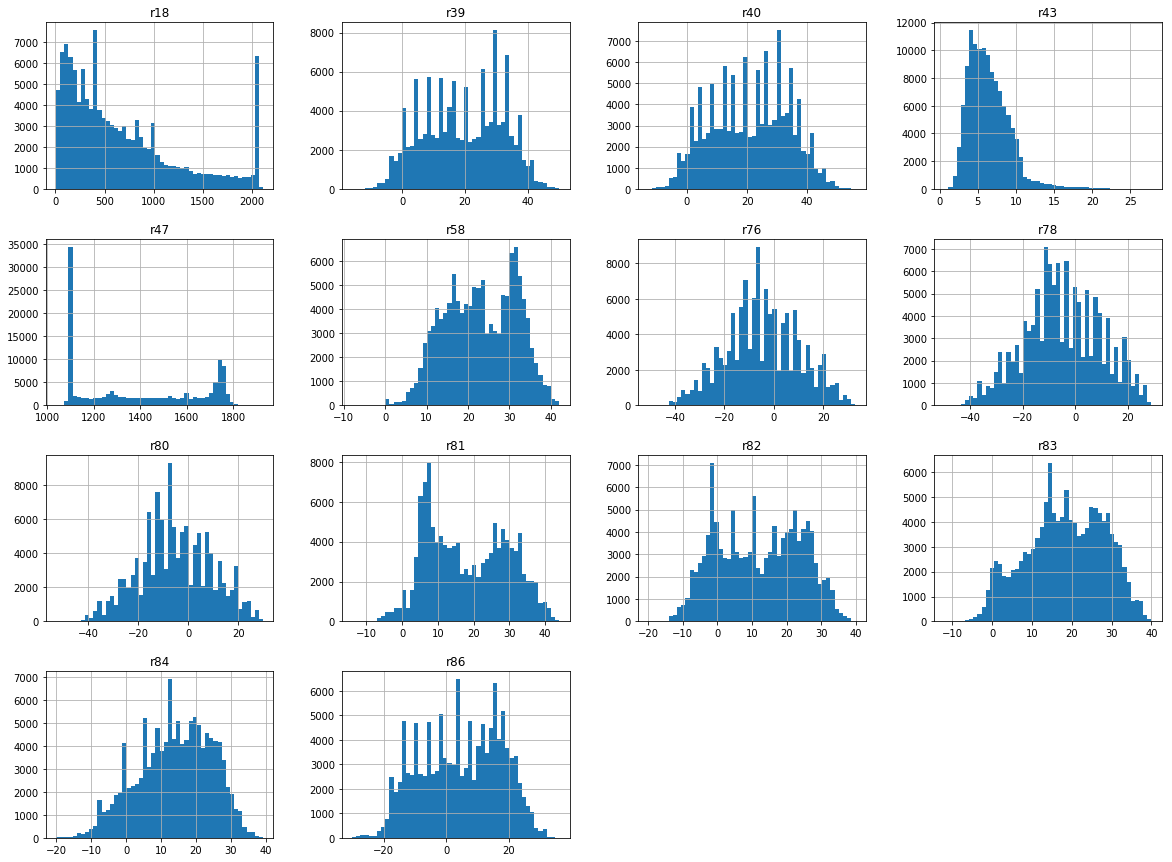

In [30]:
%matplotlib inline   
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15))
plt.show()

### 2.6 查看温度数据之间的相关性

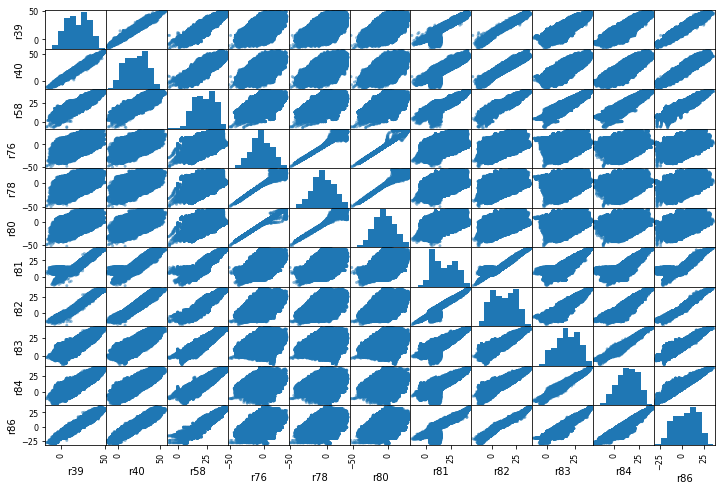

In [31]:
from pandas.plotting import scatter_matrix

attributes = ["r39", "r40", "r58", "r76", "r78", "r80", "r81", "r82", "r83", "r84", "r86"]
scatter_matrix(df[attributes], figsize=(12, 8))
plt.show()

#### 从上图可以得到以下几点结论
* r81（塔底控制柜温度）有点异常
* r76、r78、r80三者相关性很强，但与其它温度相关性较弱,温度模型，他们3个可以一起
* 剩余温度之间相关性较强

## 3 可视化展示

### 3.1 塔底控制柜温度查看（r81）

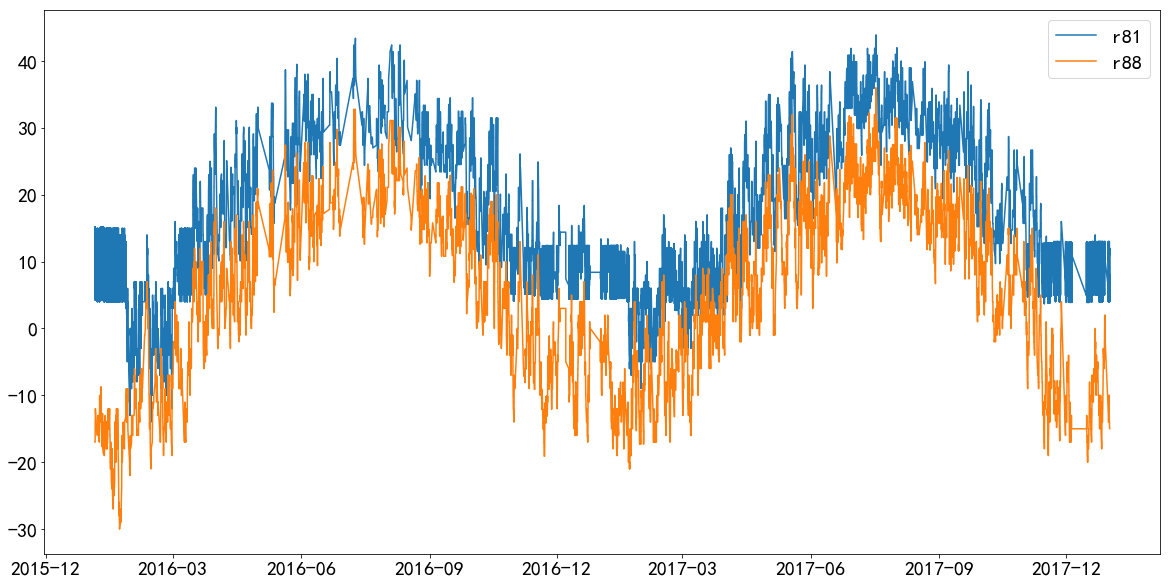

In [46]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei' #黑体
matplotlib.rcParams['font.size'] = '20'
plt.rcParams['axes.unicode_minus']=False # 解决负值不显示

plt.figure(figsize=(20,10))
plt.plot(df['r81'], alpha=1, label = 'r81')
plt.plot(df['r86'], alpha=1, label = 'r88')
plt.legend()
plt.show()

* 可以看出r81温度在年底左右是有异常的，但是其余时段与r86跟随的很好，相关性很强

### 3.2 变桨电机3个温度图展示

In [59]:
corr_matrix = df.corr()
corr_matrix["r76"].sort_values(ascending=False)

r76    1.000000
r80    0.998128
r78    0.996202
r43    0.535414
r47    0.510640
r18    0.491910
r40    0.348450
r39    0.274153
r82    0.213842
r81    0.210907
r58    0.169504
r86    0.151217
r84    0.010500
r83    0.007363
Name: r76, dtype: float64

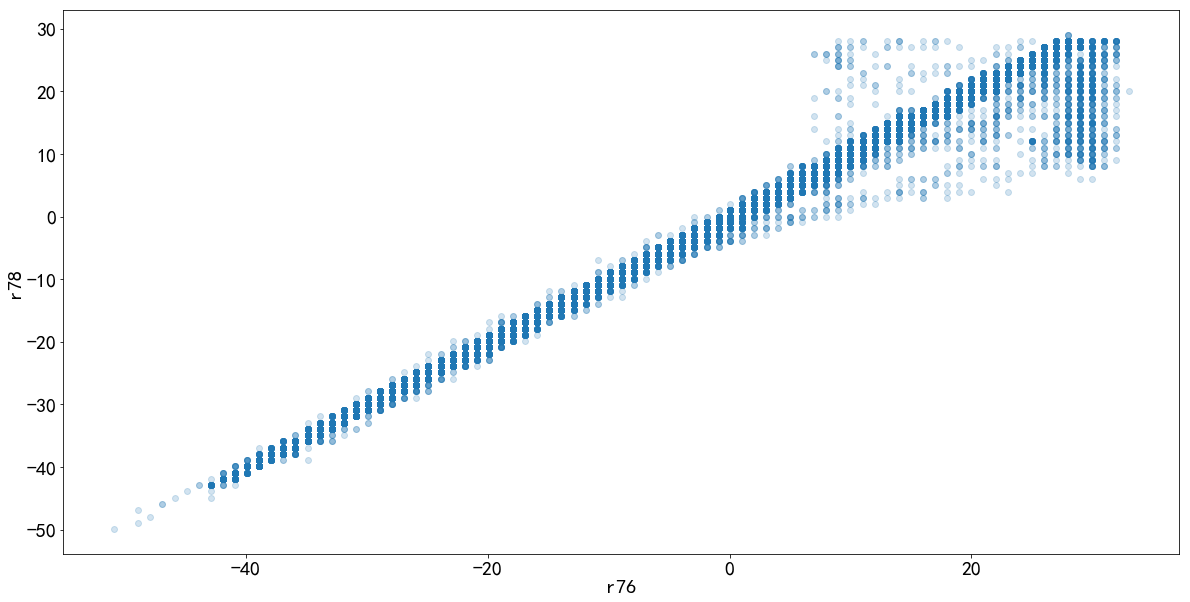

In [57]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei' #黑体
matplotlib.rcParams['font.size'] = '20'
plt.rcParams['axes.unicode_minus']=False # 解决负值不显示

plt.figure(figsize=(20,10))
plt.scatter(df['r76'], df['r78'],alpha=0.2)
plt.xlabel('r76')
plt.ylabel('r78')
plt.show()

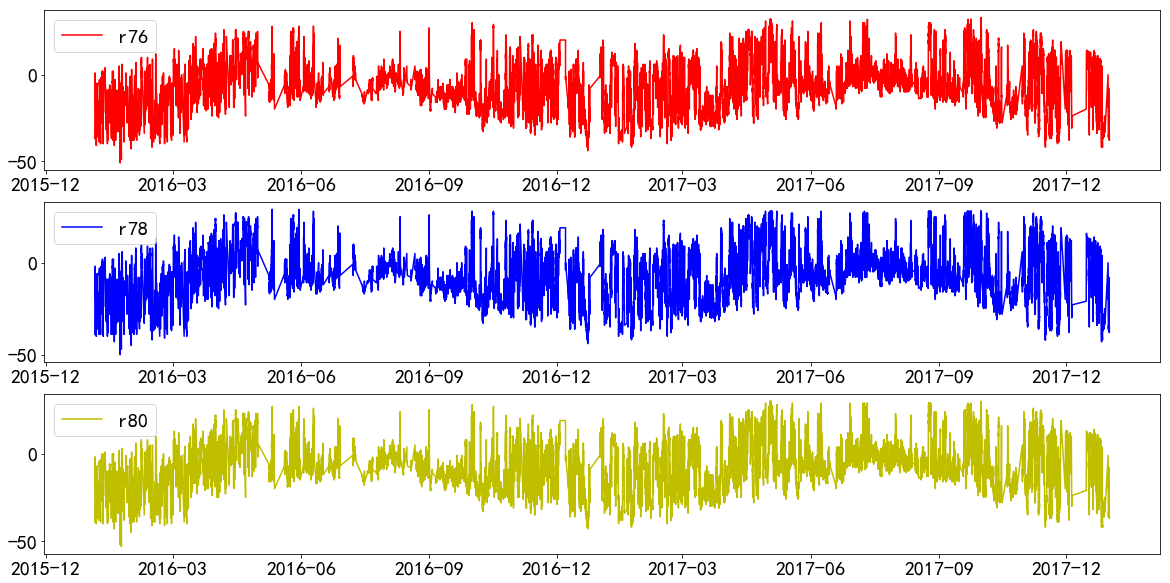

In [58]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(df['r76'], alpha=1, label = 'r76',color='r')
plt.legend()
plt.subplot(3,1,2)
plt.plot(df['r78'], alpha=1, label = 'r78',color='b')
plt.legend()
plt.subplot(3,1,3)
plt.plot(df['r80'], alpha=1, label = 'r80',color='y')
plt.legend()
plt.show()

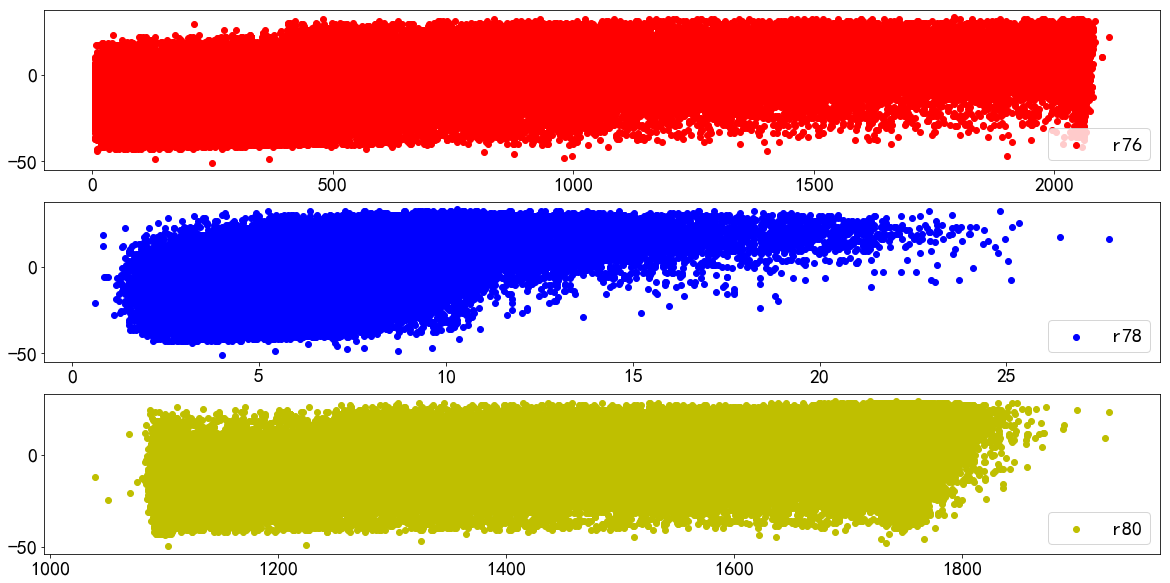

In [60]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.scatter(df['r18'].values, df['r76'].values, alpha=1, label = 'r76',color='r')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(df['r43'].values, df['r76'].values, alpha=1, label = 'r78',color='b')
plt.legend()
plt.subplot(3,1,3)
plt.scatter(df['r47'].values, df['r78'].values, alpha=1, label = 'r80',color='y')
plt.legend()
plt.show()

#### 结论： 综合分析可以看到r76，r78，r80三者最相关，其次是r43，r47，r18
###

### 3.3 剩余温度图展示

#### 3.3.1 相关度展示

In [61]:
corr_matrix1 = df.corr()
corr_matrix1["r86"].sort_values(ascending=False)

r86    1.000000
r82    0.986427
r39    0.963680
r58    0.945780
r81    0.942660
r83    0.942090
r40    0.933118
r84    0.932134
r76    0.151217
r80    0.146004
r78    0.144452
r43   -0.152271
r18   -0.155009
r47   -0.183747
Name: r86, dtype: float64

* 从上面的相关性也可以看到r86，r82，r39，r58，r81，r83，r40，r84比较相关

#### 3.3.2 按天平均展示

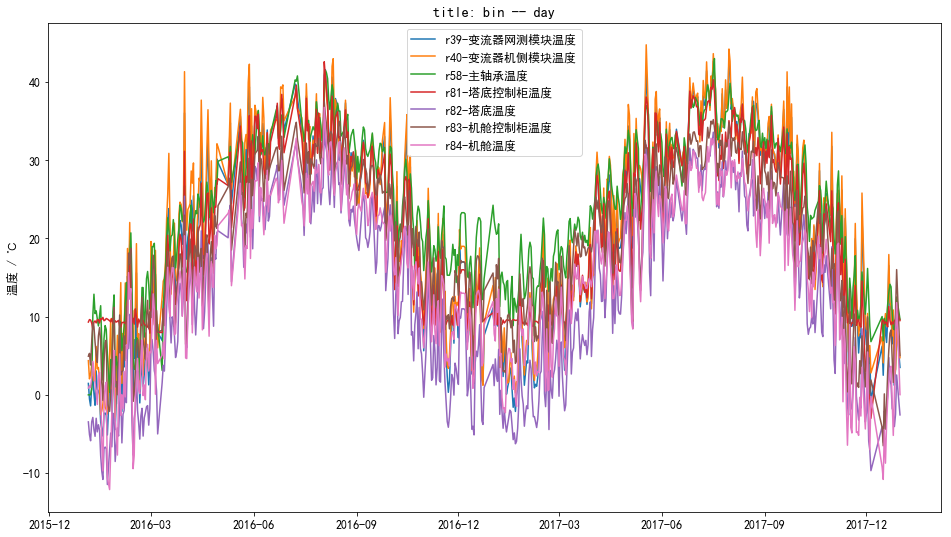

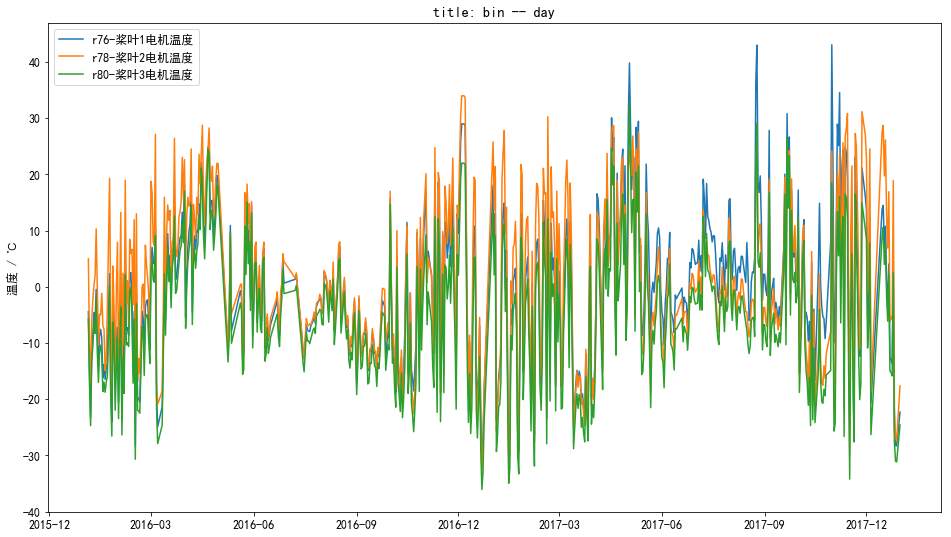

In [41]:
# 增加天列
df['year_day'] = [str(x)[: 10] for x in df.index]
gt_mean = df.groupby(df['year_day']).mean()

# 画图1
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei' #黑体
matplotlib.rcParams['font.size'] = '12' #包括坐标轴字号均改变
plt.rcParams['axes.unicode_minus']=False #解决坐标轴负值不显示问题

plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r39'].values, label='r39-变流器网测模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r40'].values, label='r40-变流器机侧模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r58'].values, label='r58-主轴承温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r81'].values, label='r81-塔底控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r82'].values, label='r82-塔底温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r83'].values, label='r83-机舱控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r84'].values, label='r84-机舱温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- day')
plt.show()

# 画图2
plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r76'].values, label='r76-桨叶1电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r78'].values, label='r78-桨叶2电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r80'].values, label='r80-桨叶3电机温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- day')
plt.show()


#### 3.3.3 按月平均展示

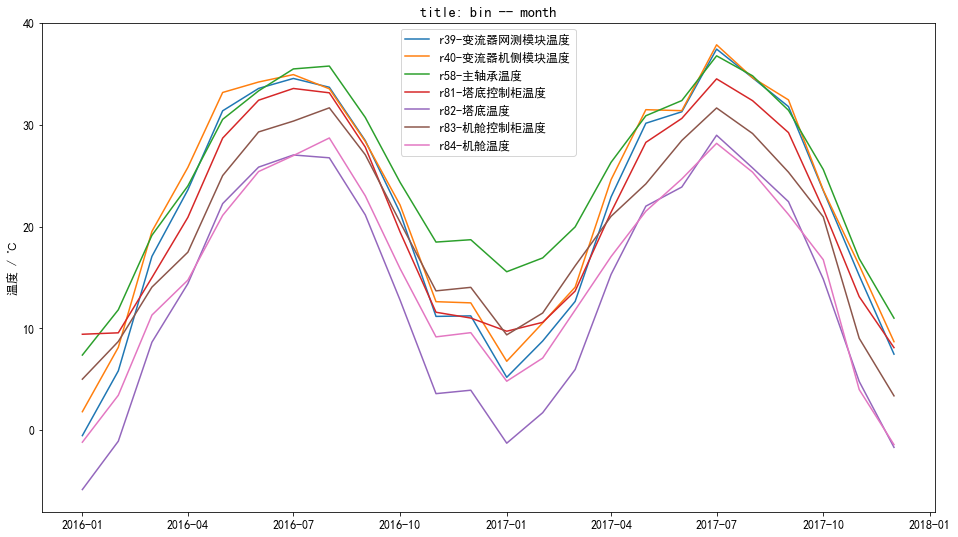

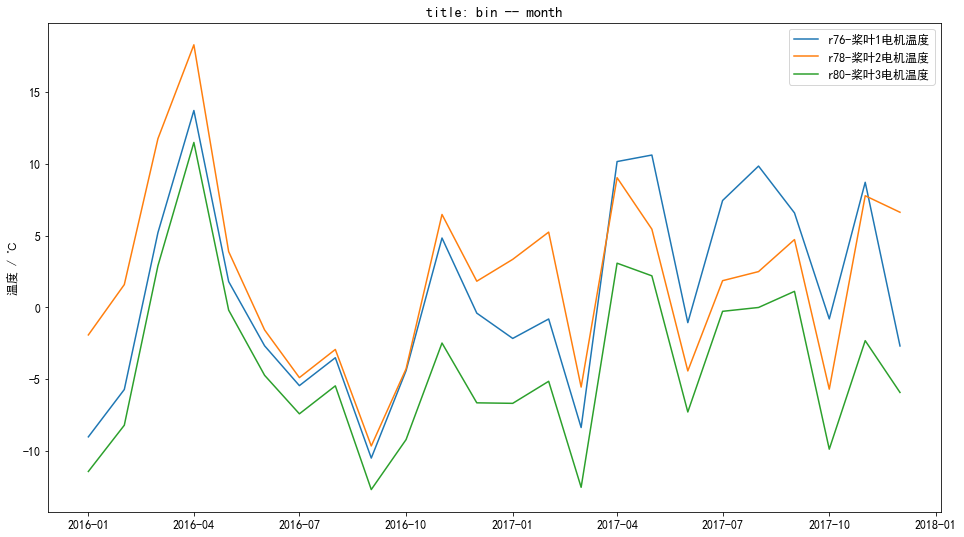

In [40]:
# 增加月列
df['year_month'] = [str(x)[: 7] for x in df.index]
gt_mean = df.groupby(df['year_month']).mean()

# 画图1
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'SimHei' #黑体
matplotlib.rcParams['font.size'] = '12' #包括坐标轴字号均改变
plt.rcParams['axes.unicode_minus']=False #解决坐标轴负值不显示问题

plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r39'].values, label='r39-变流器网测模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r40'].values, label='r40-变流器机侧模块温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r58'].values, label='r58-主轴承温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r81'].values, label='r81-塔底控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r82'].values, label='r82-塔底温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r83'].values, label='r83-机舱控制柜温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r84'].values, label='r84-机舱温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- month')
plt.show()

# 画图2
plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r76'].values, label='r76-桨叶1电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r78'].values, label='r78-桨叶2电机温度')
plt.plot(pd.to_datetime(gt_mean.index), gt_mean['r80'].values, label='r80-桨叶3电机温度')
plt.ylabel('温度 / ℃')
plt.legend()
plt.title('title: bin -- month')
plt.show()



# 4 结论

* 桨叶电机1/2/3温度，相互之间相关性很强，而与其余温度相关性不强，建议建模时，将这三个温度放在一起

* 变流器网测模块温度、变流器机侧模块温度、主轴承温度、塔底控制柜温度、塔底温度、机舱控制柜温度、机舱温度、环境温度，相关性较强，可将这些温度放在一起
